In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
from data import analyze as an
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import requests
import cv2
import io
import category_encoders as ce

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


%matplotlib inline
from matplotlib import pyplot as plt

# Enable module reloading
%load_ext autoreload
%autoreload 2

In [4]:
tr_ids, tr_labels, tr_relationships = an.load_data("../data/train/image_ids.csv", 
                                                            "../data/train/labels.csv", 
                                                            "../data/train/relationships.csv")
te_ids, te_labels, te_relationships = an.load_data("../data/test/image_ids.csv", 
                                                         "../data/test/labels.csv", 
                                                         "../data/test/relationships.csv")
val_ids, val_labels, val_relationships = an.load_data("../data/valid/image_ids.csv", 
                                                         "../data/valid/labels.csv", 
                                                         "../data/valid/relationships.csv")

In [5]:
top_labels1 = tr_relationships.groupby('LabelName1').count().sort_values('ImageID', ascending=False).head(10)['ImageID'].to_frame()

In [6]:
top_labels2 = tr_relationships.groupby('LabelName2').count().sort_values('ImageID', ascending=False).head(10)['ImageID'].to_frame()

In [7]:
for i in range(10):
    if(top_labels2.index[i] in top_labels1.index):
        top_labels1.loc[top_labels2.index[i]] += top_labels2.iloc[i].values[0]
    else:
        top_labels1 = top_labels1.append(top_labels2.iloc[i])

In [8]:
top = top_labels1.head(10).index.values

In [10]:
ids = tr_relationships[(tr_relationships['LabelName1'].isin(top)) & (tr_relationships['LabelName2'].isin(top))]['ImageID']

In [11]:
image_ids = ids.unique()

In [12]:
urls = tr_ids.loc[tr_ids['ImageID'].isin(image_ids)]['OriginalURL'].values

In [13]:
g = an.image_array_generator(urls, tr_relationships, tr_ids, batch_size=50, resize=True, size=(20,20), normalize=True)

In [15]:
data = next(g)

https://c3.staticflickr.com/9/8752/16821381540_e5a97a02a2_o.jpg
https://farm6.staticflickr.com/206/521142381_20a1a278b7_o.jpg
https://farm4.staticflickr.com/2872/9590312870_a22e790359_o.jpg
https://c7.staticflickr.com/5/4072/4709163937_65680fb454_o.jpg
https://c3.staticflickr.com/3/2013/5823183624_1233778860_o.jpg
https://farm6.staticflickr.com/2664/3887372222_635b77a39d_o.jpg
https://farm1.staticflickr.com/5568/14999922457_c94d7d119e_o.jpg
https://farm4.staticflickr.com/118/303254232_10bd8ec91d_o.jpg


In [19]:
data[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [2]:
from src.models.c_dcgan import GANColor

In [3]:
gan = GANColor((64, 64, 3))
d_model = gan.discriminator
g_model = gan.generator
g_combined = gan.combined

In [6]:
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16384)        1654784     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

In [4]:
from numpy.random import randint, randn
def generate_fake_input(n_samples):
    fake_labels = randint(0, 10, n_samples)
    x_input = randn(100 * n_samples)
    fake_noise = x_input.reshape(n_samples, 100)
    return fake_noise, fake_labels

In [5]:
g_model(generate_fake_input(2))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=885, shape=(2, 64, 64, 3), dtype=float32, numpy=
array([[[[ 3.17420694e-04, -8.02198367e-04,  1.09759148e-03],
         [-3.50128184e-03, -1.32447004e-03, -3.07261781e-03],
         [-3.09285661e-03,  3.34516051e-04, -1.22048543e-03],
         ...,
         [-1.45928643e-03, -8.13178252e-04,  9.46009182e-04],
         [ 6.53895433e-04,  4.17382875e-03, -2.11518630e-03],
         [ 1.25091011e-03, -2.30983205e-05, -6.35838427e-04]],

        [[-6.89149238e-05, -4.90897393e-04, -4.19786200e-03],
         [-2.77566537e-03, -3.53340036e-03,  2.08147825e-03],
         [ 3.07131093e-04,  1.53481041e-03,  4.13418422e-03],
         ...,
         [-4.83352342e-04,  5.14837261e-03,  9.81787452e-04],
         [-2.10956740e-03,  2.99285725e-03,  8.09827470e-04],
         [ 5.36987151e-04,  8.80796579e-04,  1.57052802e-03]],

        [[-2.02859263e-03,  2.26001861e-03, -2.26567546e-03],
         [-2.27235048e-03, -3.57258553e-03,  2.46385066e-03],
         [ 1.13541966e-04,  3.131779

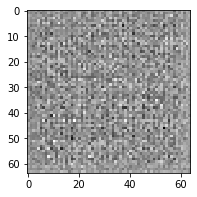

In [11]:
import tensorflow as tf
plt.rcParams["figure.figsize"] = (3,3)
noise = tf.random.normal([2, 100])
noise, labels = generate_fake_input(2)
generated_image = g_model((noise, label))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
d_model((generated_image,labels))

<tf.Tensor: id=1329, shape=(2, 1), dtype=float32, numpy=
array([[0.49980766],
       [0.49996495]], dtype=float32)>

In [13]:
g_combined((noise, label))

<tf.Tensor: id=1488, shape=(2, 1), dtype=float32, numpy=
array([[0.49996656],
       [0.4999987 ]], dtype=float32)>